* XGBoost 버전 확인

In [1]:
import xgboost

print(xgboost.__version__)

2.0.3


### 파이썬 래퍼 XGBoost 적용 – 위스콘신 유방암 예측

In [2]:
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features= dataset.data
y_label = dataset.target

cancer_df = pd.DataFrame(data=X_features, columns=dataset.feature_names)
cancer_df['target']= y_label
cancer_df.head(3)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


In [4]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label임. Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 칼럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label,
                                         test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )
print(X_train.shape , X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


In [5]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환.
# 학습, 검증, 테스트용 DMatrix를 생성.
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

In [6]:
params = { 'max_depth':3,
          'eta': 0.05,
          'objective':'binary:logistic',
          'eval_metric':'logloss'
         }
num_rounds = 400

In [7]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다.
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방.

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds , \
                      early_stopping_rounds=50, evals=eval_list )

[0]	train-logloss:0.62480	eval-logloss:0.63104
[1]	train-logloss:0.58674	eval-logloss:0.60478
[2]	train-logloss:0.55226	eval-logloss:0.58223
[3]	train-logloss:0.52086	eval-logloss:0.56184
[4]	train-logloss:0.49192	eval-logloss:0.54118
[5]	train-logloss:0.46537	eval-logloss:0.52223
[6]	train-logloss:0.44029	eval-logloss:0.50287
[7]	train-logloss:0.41666	eval-logloss:0.48620
[8]	train-logloss:0.39525	eval-logloss:0.46974
[9]	train-logloss:0.37542	eval-logloss:0.45497
[10]	train-logloss:0.35701	eval-logloss:0.44131
[11]	train-logloss:0.33982	eval-logloss:0.43134
[12]	train-logloss:0.32297	eval-logloss:0.41972
[13]	train-logloss:0.30725	eval-logloss:0.40902
[14]	train-logloss:0.29327	eval-logloss:0.39883
[15]	train-logloss:0.27946	eval-logloss:0.38968
[16]	train-logloss:0.26691	eval-logloss:0.38150
[17]	train-logloss:0.25473	eval-logloss:0.37368
[18]	train-logloss:0.24385	eval-logloss:0.36666
[19]	train-logloss:0.23338	eval-logloss:0.35994
[20]	train-logloss:0.22320	eval-logloss:0.35374
[2

In [8]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.938 0.004 0.75  0.049 0.98  1.    0.999 0.999 0.998 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[35  2]
 [ 2 75]]
정확도: 0.9649, 정밀도: 0.9740, 재현율: 0.9740,    F1: 0.9740, AUC:0.9965


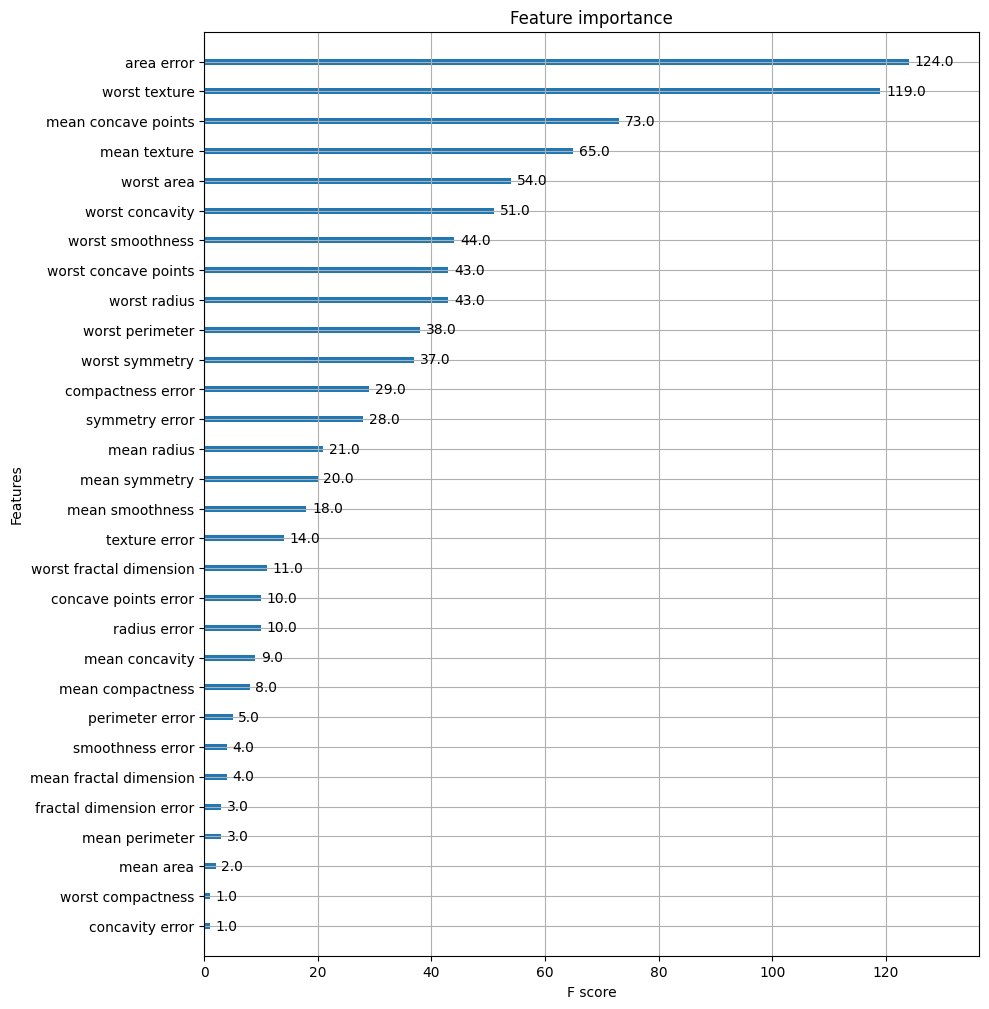

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)
plt.savefig('p239_xgb_feature_importance.tif', format='tif', dpi=300, bbox_inches='tight')

### 사이킷런 래퍼 XGBoost의 개요 및 적용

In [13]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
xgb_wrapper.fit(X_train, y_train)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [14]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[35  2]
 [ 1 76]]
정확도: 0.9737, 정밀도: 0.9744, 재현율: 0.9870,    F1: 0.9806, AUC:0.9947


In [ ]:
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.1, max_depth=3)
evals = [(X_test, y_test)]
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=100, eval_metric="logloss",
                eval_set=evals, verbose=True)

ws100_preds = xgb_wrapper.predict(X_test)
ws100_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [ ]:
get_clf_eval(y_test , ws100_preds, ws100_pred_proba)

In [ ]:
# early_stopping_rounds를 10으로 설정하고 재 학습.
xgb_wrapper.fit(X_train, y_train, early_stopping_rounds=10,
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방.
plot_importance(xgb_wrapper, ax=ax)
